# Portfolio Backtesting Engine



<img src = "./roadmap.png" height = 421 width = 750>

In [15]:
!pip install QuantStats --quiet

In [16]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import yfinance as yf
import quantstats as qs

In [17]:
def get_etf_price_data():
    tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
    etf = yf.Tickers(tickers)
    data = etf.history(start='2010-01-01', actions=False)
    data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
    data = data.droplevel(0, axis=1)
    data.ffill(inplace=True)
    df = data.resample('W').last()
    return df

df = get_etf_price_data()

[*********************100%***********************]  9 of 9 completed


In [18]:
df

Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2010-01-10 00:00:00+00:00,25.517195,37.449196,9.516922,22.150614,18.775425,17.984697,18.469481,24.842726,25.303404
2010-01-17 00:00:00+00:00,24.698763,36.803314,9.341836,22.014296,18.465752,18.120071,18.583712,25.186676,24.962038
2010-01-24 00:00:00+00:00,23.113070,34.965015,8.866621,21.082836,17.650856,17.795177,17.928381,24.748911,24.162718
2010-01-31 00:00:00+00:00,22.024281,33.847134,8.866621,20.734486,17.080421,17.734259,17.754028,24.451876,24.071117
2010-02-07 00:00:00+00:00,22.272730,33.685654,8.716549,20.598181,17.170059,17.585337,17.387287,24.100096,23.954563
...,...,...,...,...,...,...,...,...,...
2024-08-18 00:00:00+00:00,90.570000,90.470001,43.770000,126.970001,221.399994,80.510002,74.440002,152.869995,183.130005
2024-08-25 00:00:00+00:00,92.730003,90.389999,44.430000,129.279999,223.960007,81.839996,75.419998,155.449997,187.869995
2024-09-01 00:00:00+00:00,94.279999,91.279999,45.740002,131.460007,220.330002,82.510002,76.290001,157.199997,187.119995


In [6]:
# 포트폴리오 백테스팅 엔진 클래스
class PortOptimPy:
    # 초기화 함수
    def __init__(self, price, param=52):

        # 연율화 패러미터
        self.param = param

        # 일별 수익률
        self.rets = price.pct_change().dropna()

        # 기대수익률
        self.er = np.array(self.rets * self.param)

        # 변동성
        self.vol = np.array(self.rets.rolling(self.param).std() * np.sqrt(self.param))

        # 공분산행렬
        cov = self.rets.rolling(self.param).cov().dropna() * self.param
        self.cov = cov.values.reshape(int(cov.shape[0]/cov.shape[1]), cov.shape[1], cov.shape[1])

        # 거래비용
        self.cost = 0.0005

    # 횡적 배분 모델 클래스
    class CrossSectional:

        # EW
        def ew(self, er):
            noa = er.shape[0]
            weights = np.ones_like(er) * (1/noa)
            return weights
        
        # MSR
        def msr(self, er, cov):
            noa = er.shape[0]
            init_guess = np.repeat(1/noa, noa)

            bounds = ((0.0, 1.0), ) * noa
            weights_sum_to_1 = {'type': 'eq',
                                'fun': lambda weights: np.sum(weights) - 1}

            def neg_sharpe(weights, er, cov):
                r = weights.T @ er
                vol = np.sqrt(weights.T @ cov @ weights)
                return - r / vol

            weights = minimize(neg_sharpe,
                            init_guess,
                            args=(er, cov),
                            method='SLSQP',
                            constraints=(weights_sum_to_1,), 
                            bounds=bounds)

            return weights.x
        
        # GMV
        def gmv(self, cov):
            noa = cov.shape[0]
            init_guess = np.repeat(1/noa, noa)

            bounds = ((0.0, 1.0), ) * noa
            weights_sum_to_1 = {'type': 'eq',
                                'fun': lambda weights: np.sum(weights) - 1}

            def port_vol(weights, cov):
                vol = np.sqrt(weights.T @ cov @ weights)
                return vol

            weights = minimize(port_vol, init_guess, args=(cov), method='SLSQP', constraints=(weights_sum_to_1,), bounds=bounds)

            return weights.x
        
        # MDP
        def mdp(self, vol, cov):
            noa = vol.shape[0]
            init_guess = np.repeat(1/noa, noa)
            bounds = ((0.0, 1.0), ) * noa
            
            weights_sum_to_1 = {'type': 'eq',
                                'fun': lambda weights: np.sum(weights) - 1}
            
            def neg_div_ratio(weights, vol, cov):
                weighted_vol = weights.T @ vol
                port_vol = np.sqrt(weights.T @ cov @ weights)
                return - weighted_vol / port_vol
            
            weights = minimize(neg_div_ratio, 
                               init_guess, 
                               args=(vol, cov),
                               method='SLSQP',
                               constraints=(weights_sum_to_1,), 
                               bounds=bounds)
            
            return weights.x
        
        # RP
        def rp(self, cov):
            noa = cov.shape[0]
            init_guess = np.repeat(1/noa, noa)
            bounds = ((0.0, 1.0), ) * noa
            target_risk = np.repeat(1/noa, noa)
            
            weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}
            
            def msd_risk(weights, target_risk, cov):
                
                port_var = weights.T @ cov @ weights
                marginal_contribs = cov @ weights
                
                risk_contribs = np.multiply(marginal_contribs, weights.T) / port_var
                
                w_contribs = risk_contribs
                return ((w_contribs - target_risk)**2).sum()
            
            weights = minimize(msd_risk, 
                               init_guess,
                               args=(target_risk, cov), 
                               method='SLSQP',
                               constraints=(weights_sum_to_1,),
                               bounds=bounds)
            return weights.x
        
        # EMV
        def emv(self, vol):
            inv_vol = 1 / vol
            weights = inv_vol / inv_vol.sum()
    
            return weights
        
    # 종적 배분 모델 클래스 # 
    class TimeSeries: 

        # VT   
        def vt(self, port_rets, param, vol_target=0.1):
            vol = port_rets.rolling(param).std().fillna(0) * np.sqrt(param)
            weights = (vol_target / vol).replace([np.inf, -np.inf], 0).shift(1).fillna(0)
            weights[weights > 1] = 1
            return weights
        
        # CVT
        def cvt(self, port_rets, param, delta=0.01, cvar_target=0.05):
            def calculate_CVaR(rets, delta=0.01):
                VaR = rets.quantile(delta)    
                return rets[rets <= VaR].mean()
            
            rolling_CVaR = -port_rets.rolling(param).apply(calculate_CVaR, args=(delta,)).fillna(0)
            weights = (cvar_target / rolling_CVaR).replace([np.inf, -np.inf], 0).shift(1).fillna(0)
            weights[weights > 1] = 1
            return weights
        
        # KL
        def kl(self, port_rets, param):
            sharpe_ratio = (port_rets.rolling(param).mean() * np.sqrt(param) / port_rets.rolling(param).std())
            weights = pd.Series(2 * norm.cdf(sharpe_ratio) - 1, index=port_rets.index).fillna(0)
            weights[weights < 0] = 0
            weights = weights.shift(1).fillna(0)
            return weights
        
        # CPPI
        def cppi(self, port_rets, m=3, floor=0.7, init_val=1):
            n_steps = len(port_rets)
            port_value = init_val
            floor_value = init_val * floor
            peak = init_val

            port_history = pd.Series(dtype=np.float64).reindex_like(port_rets)
            weight_history = pd.Series(dtype=np.float64).reindex_like(port_rets)
            floor_history = pd.Series(dtype=np.float64).reindex_like(port_rets)

            for step in range(n_steps):
                peak = np.maximum(peak, port_value)
                floor_value = peak * floor

                cushion = (port_value - floor_value) / port_value
                weight = m * cushion

                risky_alloc = port_value * weight
                safe_alloc = port_value * (1 - weight)
                port_value = risky_alloc * (1 + port_rets.iloc[step]) + safe_alloc

                port_history.iloc[step] = port_value
                weight_history.iloc[step] = weight
                floor_history.iloc[step] = floor_value

            return weight_history.shift(1).fillna(0)
    
    # 거래비용 함수
    def transaction_cost(self, weights_df, rets_df, cost=0.0005):
        # 이전 기의 투자 가중치
        prev_weights_df = (weights_df.shift(1).fillna(0) * (1 + rets_df.iloc[self.param-1:,:])) \
        .div((weights_df.shift(1).fillna(0) * (1 + rets_df.iloc[self.param-1:,:])).sum(axis=1), axis=0)

        # 거래비용 데이터프레임
        cost_df = abs(weights_df - prev_weights_df) * cost
        cost_df.fillna(0, inplace=True)

        return cost_df

    # 백테스팅 실행 함수
    def run(self, cs_model, ts_model, cost):
        # 빈 딕셔너리
        backtest_dict = {}
        
        # 일별 수익률 데이터프레임
        rets = self.rets
        
        # 횡적 배분 모델 선택 및 실행
        for i, index in enumerate(rets.index[self.param-1:]):
            if cs_model == 'EW':
                backtest_dict[index] = self.CrossSectional().ew(self.er[i])
            elif cs_model == 'MSR':
                backtest_dict[index] = self.CrossSectional().msr(self.er[i], self.cov[i])
            elif cs_model == 'GMV':
                backtest_dict[index] = self.CrossSectional().gmv(self.cov[i])
            elif cs_model == 'MDP':
                backtest_dict[index] = self.CrossSectional().mdp(self.vol[i], self.cov[i])
            elif cs_model == 'EMV':
                backtest_dict[index] = self.CrossSectional().emv(self.vol[i])
            elif cs_model == 'RP':
                backtest_dict[index] = self.CrossSectional().rp(self.cov[i])
        
        # 횡적 가중치 데이터프레임
        cs_weights = pd.DataFrame(list(backtest_dict.values()), index=backtest_dict.keys(), columns=rets.columns)
        cs_weights.fillna(0, inplace=True)

        # 횡적 배분 모델 자산 수익률
        cs_rets = cs_weights.shift(1) * rets.iloc[self.param-1:,:]

        # 횡적 배분 모델 포트폴리오 수익률
        cs_port_rets = cs_rets.sum(axis=1)
        
        # 종적 배분 모델 선택 및 실행
        if ts_model == 'VT':
            ts_weights = (self.TimeSeries().vt(cs_port_rets, self.param))
        elif ts_model == 'CVT':
            ts_weights = (self.TimeSeries().cvt(cs_port_rets, self.param))
        elif ts_model == 'KL':
            ts_weights = (self.TimeSeries().kl(cs_port_rets, self.param))
        elif ts_model == 'CPPI':
            ts_weights = (self.TimeSeries().cppi(cs_port_rets))
        elif ts_model == None:
            ts_weights = 1

        # 최종 포트폴리오 투자 가중치
        port_weights = cs_weights.multiply(ts_weights, axis=0)

        # 거래비용 데이터프레임
        cost = self.transaction_cost(port_weights, rets)

        # 최종 포트폴리오 자산별 수익률
        port_asset_rets = port_weights.shift() * rets - cost

        # 최종 포트폴리오 수익률 
        port_rets = port_asset_rets.sum(axis=1)
        port_rets.index = pd.to_datetime(port_rets.index).strftime("%Y-%m-%d")

        return port_weights, port_asset_rets, port_rets

    # 성과분석 수행 함수
    def performance_analytics(self, port_weights, port_asset_rets, port_rets, qs_report=False):
        
        # 자산별 투자 가중치
        plt.figure(figsize=(12, 7))
        port_weights['Cash'] = 1 - port_weights.sum(axis=1)
        plt.stackplot(port_weights.index, port_weights.T, labels=port_weights.columns)
        plt.title('Portfolio Weights')
        plt.xlabel('Date')
        plt.ylabel('Weights')
        plt.legend(loc='upper left')
        plt.show()

        # 자산별 누적 수익률
        plt.figure(figsize=(12, 7))
        plt.plot((1 + port_asset_rets).cumprod() - 1)
        plt.title('Underlying Asset Performance')
        plt.xlabel('Date')
        plt.ylabel('Returns')
        plt.legend(port_asset_rets.columns, loc='upper left')
        plt.show()

        # 포트폴리오 누적 수익률
        plt.figure(figsize=(12, 7))
        plt.plot((1 + port_rets).cumprod() - 1)
        plt.title('Portfolio Performance')
        plt.xlabel('Date')
        plt.ylabel('Returns')
        plt.show()

        # QuantStats 성과분석 리포트 작성
        if qs_report == True:
            port_rets.index = pd.to_datetime(port_rets.index)
            qs.reports.html(port_rets, output='./file-name.html')

In [7]:
# 엔진 초기화
engine = PortOptimPy(df)

In [8]:
# 백테스팅 실행
res = engine.run(cs_model='RP', ts_model='VT', cost=0.0005)

In [9]:
port_weights = res[0]
port_asset_rets = res[1]
port_rets = res[2]

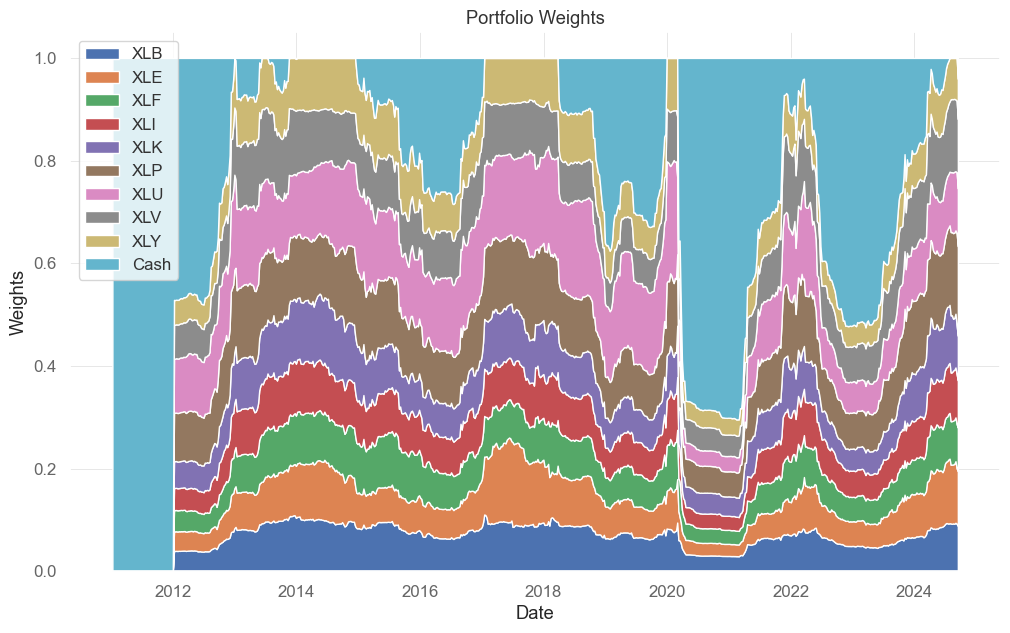

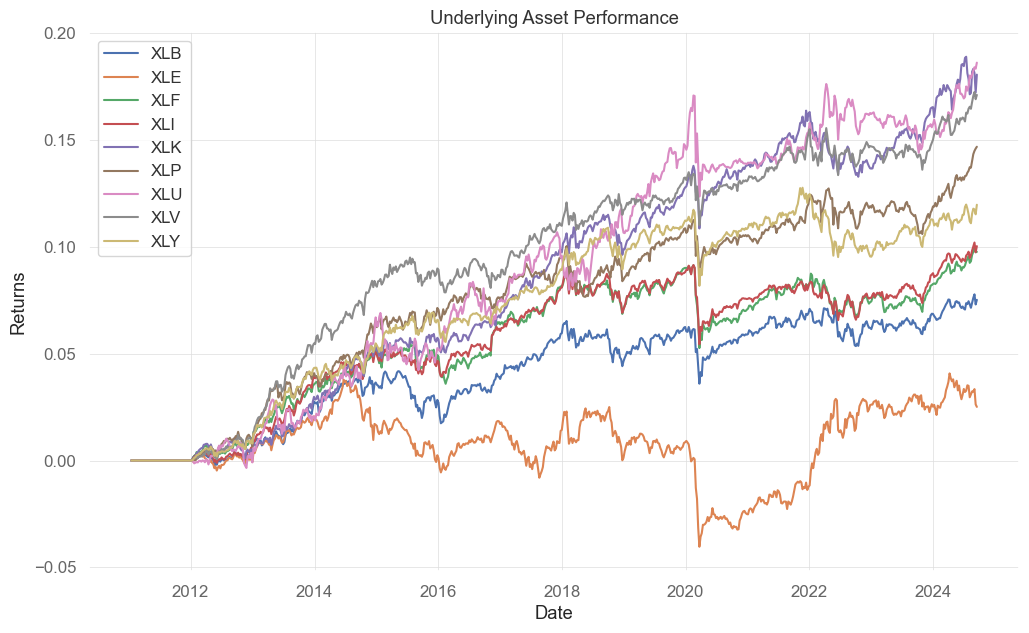

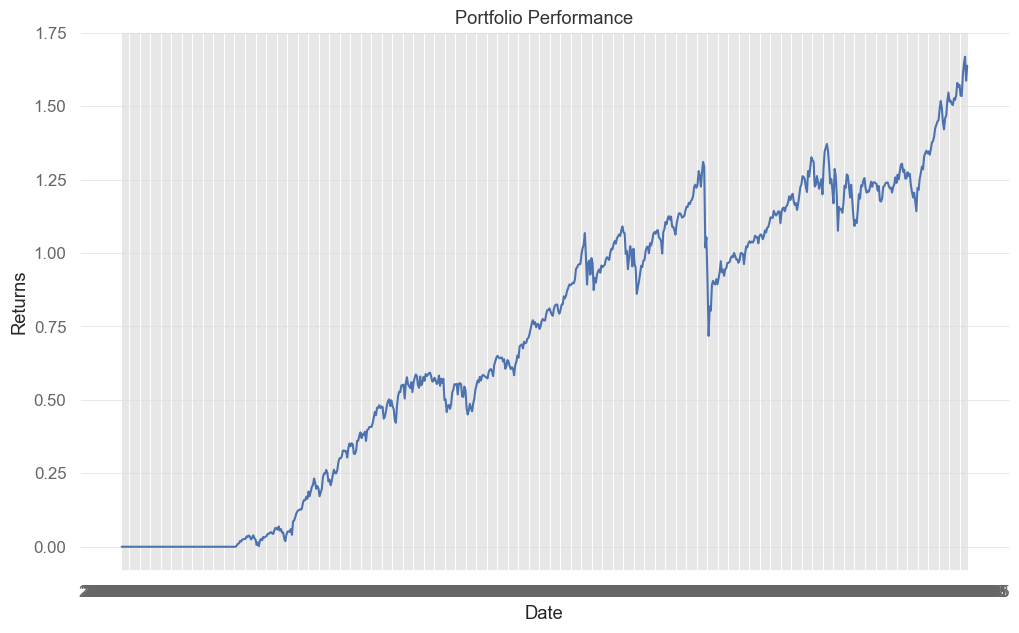

/Users/chulwonchae/.pyenv/versions/3.11.4/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/chulwonchae/.pyenv/versions/3.11.4/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/chulwonchae/.pyenv/versions/3.11.4/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

In [10]:
# 백테스팅 결과 시각화
engine.performance_analytics(port_weights, port_asset_rets, port_rets, qs_report=True)

# Appendix. 거래비용 모델링

## 재투자 가정 (복리수익률 방식)

$t$ 시점에서 자산 $i$의 거래비용
$$ cost_{i, t} = abs \left( w_{i,t} - \frac{w_{i,t-1}(1+r_{i,t})}{\Sigma w_{i,t-1}(1+r_{i,t})} \right) * tc $$

where
<br>
$ w_{i,t} $ : $t$ 시점에서 자산 $i$의 가중치 <br>
$ r_{i,t} $ : $t$ 시점에서 자산 $i$의 수익률 <br>
$ tc $ : 한 단위 거래비용(%)

<br>

## 재투자 가정 X (단리수익률 방식)

$t$ 시점에서 자산 $i$의 거래비용
$$ cost_{i, t} = abs \left( w_{i,t} - w_{i, t-1}(1 + r_{i,t}) \right) * tc $$